## TC 5033
### Word Embeddings

<br>

#### Activity 3b: Text Classification using RNNs and AG_NEWS dataset in PyTorch
<br>

- Objective:
    - Understand the basics of Recurrent Neural Networks (RNNs) and their application in text classification.
    - Learn how to handle a real-world text dataset, AG_NEWS, in PyTorch.
    - Gain hands-on experience in defining, training, and evaluating a text classification model in PyTorch.
    
<br>

- Instructions:
    - Data Preparation: Starter code will be provided that loads the AG_NEWS dataset and prepares it for training. Do not modify this part. However, you should be sure to understand it, and comment it, the use of markdown cells is suggested.

    - Model Setup: A skeleton code for the RNN model class will be provided. Complete this class and use it to instantiate your model.

    - Implementing Accuracy Function: Write a function that takes model predictions and ground truth labels as input and returns the model's accuracy.

    - Training Function: Implement a function that performs training on the given model using the AG_NEWS dataset. Your model should achieve an accuracy of at least 80% to get full marks for this part.

    - Text Sampling: Write a function that takes a sample text as input and classifies it using your trained model.

    - Confusion Matrix: Implement a function to display the confusion matrix for your model on the test data.

    - Submission: Submit your completed Jupyter Notebook. Make sure to include a markdown cell at the beginning of the notebook that lists the names of all team members. Teams should consist of 3 to 4 members.
    
<br>

- Evaluation Criteria:

    - Correct setup of all the required libraries and modules (10%)
    - Code Quality (30%): Your code should be well-organized, clearly commented, and easy to follow. Use also markdown cells for clarity. Comments should be given for all the provided code, this will help you understand its functionality.
    
   - Functionality (60%):
        - All the functions should execute without errors and provide the expected outputs.
        - RNN model class (20%)
        - Accuracy fucntion (10%)
        - Training function (10%)
        - Sampling function (10%)
        - Confucion matrix (10%)

        - The model should achieve at least an 80% accuracy on the AG_NEWS test set for full marks in this criterion.


### Team:

- Martín Jurado .................................................. A01795568
- Lineth Guerra .................................................. A01795639
- Erick Eduardo Betancourt ........................... A01795545
- Luis Alejandro González Castellanos ................. A01795481
- Jesús Armando Anaya Orozco .................... A01795464

Dataset

https://pytorch.org/text/stable/datasets.html#text-classification

https://paperswithcode.com/dataset/ag-news


#### Install libraries (if needed)

You may need to install the following libraries to ensure version compatibility. After installing them, please Restart the Session (Runtime -> Restart Session)

In [1]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchtext==0.15.2

In [2]:
!pip install scipy==1.9.3
!pip install scikit-plot
#you may receive a message of restarting session, this is OK

In [3]:
!pip install portalocker
#please restar session after this intallation. After restarting go straight to importing the libraries

## Import libraries

In [4]:
# The following libraries are required for running the given code
# Please feel free to add any libraries you consider adecuate to complete the assingment.
import numpy as np
#PyTorch libraries
import torch
from torchtext.datasets import AG_NEWS
# Dataloader library
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
# Libraries to prepare the data
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.data.functional import to_map_style_dataset
# neural layers
from torch import nn
from torch.nn import functional as F

# These libraries are suggested to plot confusion matrix
# you may use others
import scikitplot as skplt
import gc

In [5]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Get the train and the test datasets and dataloaders

Classes:

* 1 - World

* 2 - Sports

* 3 - Business

* 4 - Sci/Tech

We will convert them to:

* 0 - World

* 1 - Sports

* 2 - Business

* 3 - Sci/Tech

In [6]:
train_dataset, test_dataset = AG_NEWS()
train_dataset, test_dataset = to_map_style_dataset(train_dataset), to_map_style_dataset(test_dataset)

In [7]:
# Get the tokeniser
# tokeniser object
tokeniser = get_tokenizer('basic_english')

def yield_tokens(data):
    for _, text in data:
        yield tokeniser(text)

In [8]:
# Build the vocabulary
vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
#set unknown token at position 0
vocab.set_default_index(vocab["<unk>"])

In [9]:
#test tokens
tokens = tokeniser('Welcome to TC5033')
print(tokens, vocab(tokens))

['welcome', 'to', 'tc5033'] [3314, 4, 0]


In [10]:
NUM_TRAIN = int(len(train_dataset)*0.9)
NUM_VAL = len(train_dataset) - NUM_TRAIN

In [11]:
# set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


In [12]:
train_dataset, val_dataset = random_split(train_dataset, [NUM_TRAIN, NUM_VAL])

In [13]:
print(len(train_dataset), len(val_dataset), len(test_dataset))

108000 12000 7600


In [14]:
# function passed to the DataLoader to process a batch of data as indicated
def collate_batch(batch):
    # Get label and text
    y, x = list(zip(*batch))

    # Create list with indices from tokeniser
    x = [vocab(tokeniser(text)) for text in x]
    x = [t + ([0]*(max_tokens - len(t))) if len(t) < max_tokens else t[:max_tokens] for t in x]

    # Prepare the labels, by subtracting 1 to get them in the range 0-3
    return torch.tensor(x, dtype=torch.int32), torch.tensor(y, dtype=torch.int32) - 1

In [15]:
labels =  ["World", "Sports", "Business", "Sci/Tech"]
max_tokens = 50
BATCH_SIZE = 256

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_batch, shuffle = True)

### Let us build our RNN model

In [17]:
EMBEDDING_SIZE = 300
NEURONS = 256
LAYERS = 2
NUM_CLASSES = 4

In [47]:
def accuracy(model, loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # Disable gradient computation
        for x, y in loader:
            x, y = x.to(device), y.to(device)  # Ensure data is on the correct device
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class for each sample
            total += y.size(0)  # Total number of samples
            correct += (predicted == y).sum().item()  # Count correct predictions
    
    model.train()  # Set the model back to training mode
    return correct / total  # Return accuracy as a proportion

In [48]:
def train(model, optimiser, epochs=100):
    model.train()
    for epoch in range(epochs):
        for x, y in train_loader:
            x, y = x.to(device), y.to(device).long()  # Convert y to LongTensor
            optimiser.zero_grad()
            outputs = model(x)
            loss = F.cross_entropy(outputs, y)
            loss.backward()
            optimiser.step()
        val_acc = accuracy(model, val_loader)
        print(f"Epoch {epoch+1}, Loss: {loss.item()}, Validation Accuracy: {val_acc}")


### Example 1: RNN model

In the following model architecture, we will use an embedding layer to convert the words into vectors, followed by an RNN layer and a linear layer to make the final prediction.

We decided to add a Dropout of 0.3 to the RNN layer, and to the forward method, as a regularization technique to prevent overfitting (Zeremba et al., 2014).

Reference:

Zaremba, W., Sutskever, I., & Vinyals, O. (2014). Recurrent Neural Network Regularization. arXiv preprint arXiv:1409.2329.

In [108]:
class RNN_Model_1(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        
        # Embedding layer to convert token indices to embeddings
        self.embedding_layer = nn.Embedding(
            num_embeddings=len(vocab),
            embedding_dim=embed_size
        )
        
        # complete this code/
        # You may use PyTorch nn.GRU(), nn.RNN(), or nn.LSTM()
        
        self.rnn = nn.RNN(
            input_size=embed_size,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=0.3  # Dropout for RNN layers if more than 1 layer
        )
        
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden, num_classes) 

    def forward(self, x):
        embedded = self.embedding_layer(x)
        
        # Forward pass through the RNN
        output, _ = self.rnn(embedded)
        
        # Take the last output from the sequence for classification
        output = output[:, -1, :]
        
        # Apply dropout after RNN for additional regularization
        output = F.dropout(output, p=0.3, training=self.training)
        
        # Fully connected layer for final output
        return self.fc(output)


Running first example using a RNN model

In [115]:
# Added seed for reproducibility
torch.manual_seed(42)

epochs = 10
lr = 0.0001
# instantiate model
rnn_model = RNN_Model_1(EMBEDDING_SIZE, 512, 2, NUM_CLASSES)
rnn_model.to(device)

# The adam optimiser is used, we added the weight decay parameter to regularize the weights, for suggestion of the professor, it is fixed at 1e-4
optimiser = torch.optim.Adam(rnn_model.parameters(), lr=lr, weight_decay=1e-4)


Training the RMM model example with the selected parameters

- embedding_size = 300
- neurons = 512
- layers = 2
- classes = 4

In [116]:
# Added seed for reproducibility
torch.manual_seed(42)

train(rnn_model, optimiser=optimiser,  epochs=epochs)

Epoch 1, Loss: 1.1429535150527954, Validation Accuracy: 0.46108333333333335
Epoch 2, Loss: 0.8826776742935181, Validation Accuracy: 0.6730833333333334
Epoch 3, Loss: 0.5544078946113586, Validation Accuracy: 0.7511666666666666
Epoch 4, Loss: 0.5945878624916077, Validation Accuracy: 0.772
Epoch 5, Loss: 0.6064885258674622, Validation Accuracy: 0.80125
Epoch 6, Loss: 0.5066425800323486, Validation Accuracy: 0.7936666666666666
Epoch 7, Loss: 0.46621331572532654, Validation Accuracy: 0.8188333333333333
Epoch 8, Loss: 0.5153234601020813, Validation Accuracy: 0.8335833333333333
Epoch 9, Loss: 0.42969444394111633, Validation Accuracy: 0.8310833333333333
Epoch 10, Loss: 0.47421783208847046, Validation Accuracy: 0.8368333333333333


In [117]:
print(f'{accuracy(rnn_model, test_loader):.4f}')

0.8397


### GRU model

In [101]:
class GRU_Model(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        
        # Embedding layer to convert token indices to embeddings
        self.embedding_layer = nn.Embedding(
            num_embeddings=len(vocab),
            embedding_dim=embed_size
        )
        
        # GRU layer for improved sequence handling
        self.rnn = nn.GRU(
            input_size=embed_size,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=0.3  # Dropout between GRU layers if layers > 1
        )
        
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden, num_classes) 

    def forward(self, x):
        embedded = self.embedding_layer(x)
        
        # Forward pass through the GRU
        output, _ = self.rnn(embedded)
        
        # Take the last output from the sequence for classification
        output = output[:, -1, :]
        
        # Apply dropout after GRU for additional regularization
        output = F.dropout(output, p=0.3, training=self.training)
        
        # Fully connected layer for final output
        return self.fc(output)


In [102]:
# Added seed for reproducibility
torch.manual_seed(42)

epochs = 10
lr = 0.001
# instantiate model
gru_model = GRU_Model(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
gru_model.to(device)

# The adam optimiser is used, we added the weight decay parameter to regularize the weights, for suggestion of the professor, it is fixed at 1e-4
optimiser = torch.optim.Adam(gru_model.parameters(), lr=lr, weight_decay=1e-4)

In [103]:
# Added seed for reproducibility
torch.manual_seed(42)

# Training the model with the GRU architecture
train(gru_model, optimiser=optimiser,  epochs=epochs)

Epoch 1, Loss: 0.3126358687877655, Validation Accuracy: 0.8740833333333333
Epoch 2, Loss: 0.2841982841491699, Validation Accuracy: 0.88925
Epoch 3, Loss: 0.20336447656154633, Validation Accuracy: 0.88275
Epoch 4, Loss: 0.24331273138523102, Validation Accuracy: 0.9029166666666667
Epoch 5, Loss: 0.314243882894516, Validation Accuracy: 0.9106666666666666
Epoch 6, Loss: 0.21448835730552673, Validation Accuracy: 0.90975
Epoch 7, Loss: 0.14651770889759064, Validation Accuracy: 0.9121666666666667
Epoch 8, Loss: 0.23195186257362366, Validation Accuracy: 0.9173333333333333
Epoch 9, Loss: 0.16697660088539124, Validation Accuracy: 0.9201666666666667
Epoch 10, Loss: 0.16202130913734436, Validation Accuracy: 0.9184166666666667


In [104]:
# Validation accuracy of the model with the GRU architecture on the test set
print(f'{accuracy(gru_model, test_loader):.4f}')

0.9163


### LSTM model example

In [94]:
class LSTM_Model(nn.Module):
    def __init__(self, embed_size, hidden, layers, num_classes):
        super().__init__()
        
        # Embedding layer to convert token indices to embeddings
        self.embedding_layer = nn.Embedding(
            num_embeddings=len(vocab),
            embedding_dim=embed_size
        )
        
        # LSTM layer for improved sequence handling
        self.rnn = nn.LSTM(
            input_size=embed_size,
            hidden_size=hidden,
            num_layers=layers,
            batch_first=True,
            dropout=0.3  # Dropout between LSTM layers if layers > 1
        )
        
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden, num_classes) 

    def forward(self, x):
        embedded = self.embedding_layer(x)
        
        # Forward pass through the LSTM
        output, (hidden, cell) = self.rnn(embedded)
        
        # Take the last hidden state from the sequence for classification
        output = hidden[-1]
        
        # Apply dropout after LSTM for additional regularization
        output = F.dropout(output, p=0.3, training=self.training)
        
        # Fully connected layer for final output
        return self.fc(output)


In [95]:
# Added seed for reproducibility
torch.manual_seed(42)

epochs = 10
lr = 0.001
# instantiate model
lstm_model = LSTM_Model(EMBEDDING_SIZE, NEURONS, LAYERS, NUM_CLASSES)
lstm_model.to(device)

# The adam optimiser is used, we added the weight decay parameter to regularize the weights, for suggestion of the professor, it is fixed at 1e-4
optimiser = torch.optim.Adam(lstm_model.parameters(), lr=lr, weight_decay=1e-4)


In [96]:
# Added seed for reproducibility
torch.manual_seed(42)

# Training the model with the LSTM architecture
train(lstm_model, optimiser=optimiser,  epochs=epochs)

Epoch 1, Loss: 0.4080354571342468, Validation Accuracy: 0.85225
Epoch 2, Loss: 0.36314302682876587, Validation Accuracy: 0.86875
Epoch 3, Loss: 0.27095863223075867, Validation Accuracy: 0.87475
Epoch 4, Loss: 0.2793137729167938, Validation Accuracy: 0.89875
Epoch 5, Loss: 0.3000762164592743, Validation Accuracy: 0.9038333333333334
Epoch 6, Loss: 0.2528683841228485, Validation Accuracy: 0.9090833333333334
Epoch 7, Loss: 0.18264101445674896, Validation Accuracy: 0.9108333333333334
Epoch 8, Loss: 0.3281090259552002, Validation Accuracy: 0.9025
Epoch 9, Loss: 0.20880088210105896, Validation Accuracy: 0.9145833333333333
Epoch 10, Loss: 0.20069101452827454, Validation Accuracy: 0.9184166666666667


In [97]:
# Validation accuracy of the model with the LSTM architecture on the test set
print(f'{accuracy(lstm_model, test_loader):.4f}')

0.9196


In [105]:
def sample_text(model, loader):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        for x, y in loader:
            x, y = x.to(device), y.to(device)  # Ensure data is on the correct device
            outputs = model(x)
            _, predicted = torch.max(outputs, 1)  # Get the predicted class for each sample
            return x, y, predicted

In [106]:
sample_text(rnn_model, test_loader)

(tensor([[ 796,  675,    0,  ...,    0,    0,    0],
         [  78,    1,  395,  ...,    0,    0,    0],
         [1050,  591, 1901,  ...,    0,    0,    0],
         ...,
         [2713,  477,  267,  ...,   79,  800,    4],
         [   5, 2710,  617,  ..., 1923,    8, 1970],
         [6049, 9710,  195,  ...,    0,    0,    0]], device='cuda:0',
        dtype=torch.int32),
 tensor([2, 1, 2, 0, 0, 1, 1, 2, 1, 1, 2, 3, 2, 3, 3, 3, 1, 3, 2, 0, 0, 3, 0, 1,
         2, 1, 2, 3, 0, 0, 1, 3, 0, 2, 1, 1, 0, 0, 3, 0, 0, 3, 2, 1, 0, 2, 1, 0,
         1, 2, 0, 2, 2, 2, 2, 0, 2, 0, 1, 3, 3, 3, 2, 3, 1, 0, 0, 1, 1, 1, 2, 0,
         1, 2, 3, 3, 1, 1, 0, 2, 3, 1, 1, 3, 2, 1, 0, 3, 1, 3, 1, 1, 2, 3, 0, 1,
         2, 3, 0, 3, 0, 2, 1, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 1, 2, 2, 1, 3, 2, 1,
         2, 3, 3, 3, 3, 1, 3, 0, 0, 0, 3, 1, 0, 1, 1, 2, 0, 2, 3, 1, 3, 1, 0, 0,
         3, 0, 1, 3, 3, 3, 0, 3, 1, 3, 2, 2, 0, 1, 1, 2, 1, 0, 1, 0, 3, 1, 0, 2,
         0, 3, 0, 0, 2, 2, 2, 1, 2, 3, 0, 0, 2, 3, 2, 2

3501

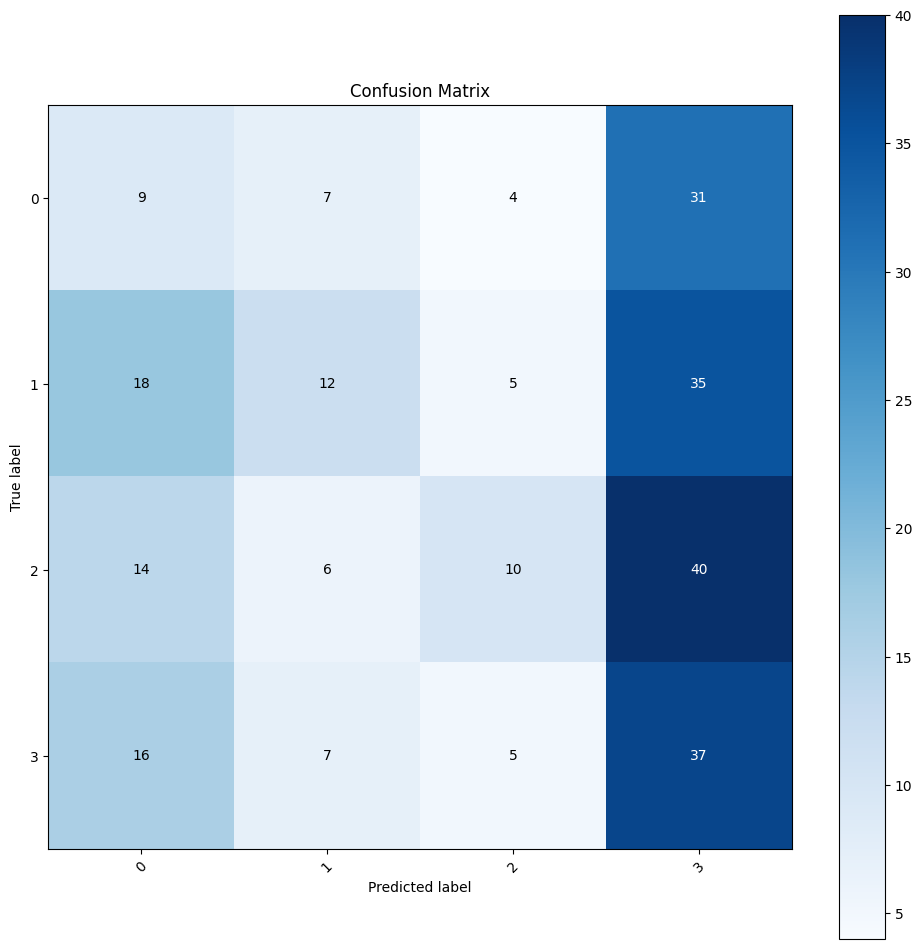

In [107]:
# create confusion matrix
x, y, predicted = sample_text(rnn_model, test_loader)
skplt.metrics.plot_confusion_matrix(y.cpu(), predicted.cpu(), figsize=(12,12), x_tick_rotation=45)
gc.collect()

